# Implementation



In [1]:
import collections
import datetime
import glob
import pathlib
import pandas as pd
import seaborn as sns
# import tensorflow as tf
import os
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython import display
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from pathlib import Path
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.autograd import Variable
import torch
import numpy as np
from scipy import signal

def plot_specgram(waveform, sample_rate):
    f, t, Sxx = signal.spectrogram(waveform, sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [2]:
import torchaudio
noise_whole = r"/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real_2sec_divided/noises/machine.wav"
noise_whole, sr = torchaudio.load(noise_whole)

new_sample_rate = 16000
resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
noise_whole = resampler(noise_whole)
print("old sr:", sr)
print("new sr:", new_sample_rate)

print(noise_whole.shape)
stop = 30
noise_sample1 = noise_whole[:,  int(1*sr):int(stop*sr)]
noise_sample2 = noise_whole[:,  int(stop*sr):int((stop+5)*sr)]
print(noise_sample2.shape)

old sr: 48000
new sr: 16000
torch.Size([1, 4048740])
torch.Size([1, 240000])


# Data Processing & Preparation.

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Create datasets and data loaders
train_tensor = torch.tensor(noise_sample1, dtype=torch.float32).view(1,1,-1)
test_tensor = torch.tensor(noise_sample2, dtype=torch.float32).view(1,1,-1)



/tmp/ipykernel_1162117/3473300325.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(noise_sample1, dtype=torch.float32).view(1,1,-1)
/tmp/ipykernel_1162117/3473300325.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(noise_sample2, dtype=torch.float32).view(1,1,-1)


In [4]:

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

betas=get_named_beta_schedule("linear", 200)

alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
white_noise_diffusion2 = torch.normal(0,1,test_tensor.shape)
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))
t = np.random.randint(1,200,1)
cur_g_t = g_t[t]
real_Vtrain = train_tensor + white_noise_diffusion*g_t[t]
real_Vtest = test_tensor + white_noise_diffusion2*g_t[t]
# train_tensor = real_Vtrain
# test_tensor = real_Vtest
real_Vtrain.shape


torch.Size([1, 1, 1392000])

In [5]:
train_full_tensors = train_tensor.squeeze().repeat(200,1).view(200,1,-1)
for i in range(200):
    cur_white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
    train_full_tensors[i,:,:] = train_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
for i in range(200):
    cur_white_noise_diffusion = torch.normal(0,1,test_tensor.shape)
    test_full_tensors[i,:,:] = test_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

In [6]:
import os
import pandas as pd
from torch.utils.data import Dataset


class NoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor[idx]
        return item, cur_gt

In [7]:
#Create TensorDatasets
train_dataset = NoiseDataset(train_full_tensors,g_t)
test_dataset = NoiseDataset(test_full_tensors,g_t)

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [8]:
train_dataset.__len__()

200

In [9]:
def calc_stft(tensor):

    # Parameters
    sample_rate = 16000  # Sample rate in Hz
    n_fft = 512  # Number of FFT points
    win_length = n_fft  # Window length
    hop_length = int(win_length/2)  # Number of samples between frames
    window = torch.hann_window(win_length)  # Window function

    signal_ = tensor.view(-1)
    duration = max(tensor.shape)

    stft = torch.stft(signal_, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)
    return stft, duration, sample_rate

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    
from scipy.signal import firwin
def fir_filter(tensor, high=False, cutoff=6000,num_taps=101,device="cpu",sample_rate=16000):
    cutoff_freq = cutoff  # Cutoff frequency for the high-pass filter in Hz
    num_taps = num_taps  # Filter order (number of filter coefficients)
    if high:
        pass_zero = False
    else:
        pass_zero = True
    coefficients = firwin(num_taps, cutoff=cutoff_freq, pass_zero=pass_zero, fs=sample_rate)

    # Convert filter coefficients to a PyTorch tensor
    coefficients = torch.tensor(coefficients, dtype=torch.float32).to(device)

    pad_length = (num_taps - 1) // 2
    signal_padded = torch.nn.functional.pad(tensor.view(1, 1, -1), (pad_length, pad_length), mode='constant').to(device)

    # Apply the FIR filter to the signal using convolution
    filtered_signal = torch.nn.functional.conv1d(signal_padded.view(1, 1, -1), coefficients.view(1, 1, -1))
    return filtered_signal

In [10]:
from IPython import display
display.display(display.Audio(filtered_signal.view(1,-1), rate=sr))

NameError: name 'filtered_signal' is not defined

In [ ]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation +1
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1d(1, 2, kernel_size=3, dilation=1)

    def forward(self, x, cur_gt):
        x = self.conv1(x)
        # print("self.conv1.padding: ", self.conv1.padding)
        if self.conv1.padding[0] != 0:
            x = x[:, :, :-self.conv1.padding[0]-1]  # remove trailing padding
        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood

In [ ]:
from torch import nn
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation +1
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class CausalConv1dClass(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation +1
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]-1]
        return output


class NetworkDivided(nn.Module):
    def __init__(self, kernel_size=25):
        super().__init__()   
        self.conv0 = CausalConv1dClass(1, 2, kernel_size=kernel_size, dilation=10)
        self.tanh0 = nn.Tanh()
        self.tanh0_1 = nn.Tanh()
        self.sig0 = nn.Sigmoid()
        self.conv1 = CausalConv1dClass(1, 2, kernel_size=kernel_size, dilation=1)
        self.tanh = nn.Tanh()
        self.tanh1_1 = nn.Tanh()
        self.sig1 = nn.Sigmoid()
        self.conv2 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=2)
        self.tanh2 = nn.Tanh()
        self.tanh2_1 = nn.Tanh()
        self.sig2 = nn.Sigmoid()
        self.conv3 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=4)
        self.tanh3 = nn.Tanh()
        self.tanh3_1 = nn.Tanh()
        self.sig3 = nn.Sigmoid()
        self.conv4 = CausalConv1dClass(2, 2, kernel_size=kernel_size, dilation=8)
        self.param = nn.Parameter(torch.randn(1))
        
        # fc_layer = nn.Linear(in_features=128, out_features=64)

    def forward(self, x, cur_gt):
        x1 = self.conv0(x)
        
        x = self.conv1(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x = torch.tanh(filter) * torch.sigmoid(gate)

        identity=x[:]
        x = x+x1
        x = self.tanh(x)
        x = self.conv2(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x = self.tanh0_1(filter) * self.sig0(gate)

        identity2=x[:]
        x = identity+x
        x = self.tanh2(x)
        x = self.conv3(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x =  self.tanh1_1(filter) * self.sig1(gate)

        identity3=x[:]
        x = x+identity2+identity
        x = self.tanh3(x)
        x = self.conv4(x)
        # gate, filter = torch.chunk(x, 2, dim=1)
        # x =  self.tanh2_1(filter) * self.sig2(gate)

        x = x+identity2+identity+identity3

        means = x[:,0,:]
        log_var = x[:,1,:]
        stds = torch.exp(0.5 *log_var)
        stds = torch.abs(means)/4
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze()
        means_=expected_means.squeeze()
        stds_ = expected_stds.squeeze()

        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        
            
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        loss3 = torch.sum(expected_stds,axis=-1)
        return -model_likelihood + self.param*loss3/wav_tensor.shape[-1]

In [ ]:
loss_array = {}
loss_test_array = {}

def train(nets, steps):
    for i in steps:
        model = nets[i]
        min_test_loss = 1000000000
        # if i ==1:
        #     break
        model.to("cuda")
        model.train()

        optimizer = optim.Adam(model.parameters())
        for epoch in range(epochs):
            running_loss = 0.0
            # for batch_idx, (batch_tensor, gt_tensor) in enumerate(train_loader):
            batch_tensor, gt_tensor = train_dataset.__getitem__(i)
            # batch_tensor = fir_filter(batch_tensor,high=high)
            # for data in train_loader:
            optimizer.zero_grad()
            batch_tensor = batch_tensor.view(1,1,-1).to("cuda", dtype=torch.float)
            gt_tensor = gt_tensor.to("cuda", dtype=torch.float)
            # print("batch_tensor.shape:",batch_tensor.shape)
            # print()
            means, stds = model(batch_tensor,gt_tensor )


            loss = model.casual_loss( means, stds, wav_tensor=batch_tensor)
            # print("loss",loss)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                
            if epoch%50==0:
                print(epoch)
            if epoch%10==0 or i > 90:
                with torch.no_grad():
                    test_inputs, gt_test = test_dataset.__getitem__(i)
                    # test_inputs = fir_filter(test_inputs,high=True)
                    test_inputs = test_inputs.view(1,1,-1).to("cuda", dtype=torch.float)
                    gt_test = gt_test.to("cuda", dtype=torch.float)
                    meanst, stdst = model(test_inputs, gt_test)
                loss_t = model.casual_loss( meanst, stdst, wav_tensor=test_inputs)
                if i in loss_test_array:
                    loss_test_array[i].append(float(loss_t))
                else:
                    loss_test_array[i] = [float(loss_t)]
                # if loss_t<=min_test_loss or epoch<10:
                min_test_loss = loss_t
                # else:
                #     break
            

            if i in loss_array:
                loss_array[i].append(float(loss))
            else:
                loss_array[i] = [float(loss)]
        nets[i].parameters = model.parameters
        print(f"Model {i} Epoch {epoch+1}/{epochs}, Loss: {running_loss}, test Loss: {loss_t}")
    return nets, loss_array, loss_test_array

In [ ]:
import matplotlib.pyplot as plt
j=199
def plot_loss(loss_array,loss_test_array,j):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(loss_array[j])
    axs[0].set_title('loss_array')
    axs[1].plot(loss_test_array[j])
    axs[1].set_title('loss_test_array')

0
50
100
150
200
250
Model 0 Epoch 300/300, Loss: 9507228.0, test Loss: tensor([1638279.3750], device='cuda:0', grad_fn=<AddBackward0>)


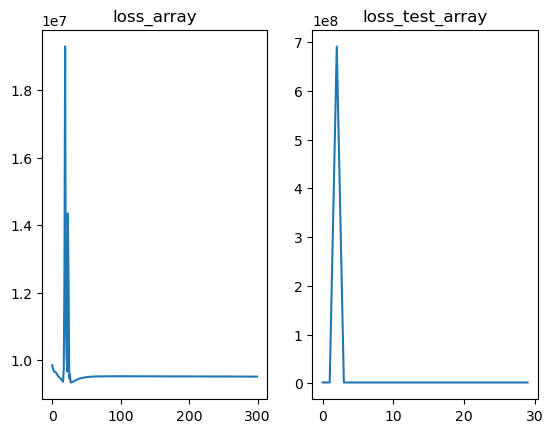

In [ ]:
import torch.optim as optim
nets_smpl = [NetworkDivided() for i in range(200)]
epochs = 300

loss_array = {}
loss_test_array = {}

nets_smpl,loss_array_low,loss_test_array_low = train(nets=nets_smpl,steps=[0])
# plot_loss(loss_array_low,loss_test_array_low,199)
# plot_loss(loss_array_low,loss_test_array_low,50)
plot_loss(loss_array_low,loss_test_array_low,0)


0
50
100
150
200
250
Model 0 Epoch 300/300, Loss: 9687392.0, test Loss: tensor([1663604.7500], device='cuda:0', grad_fn=<AddBackward0>)


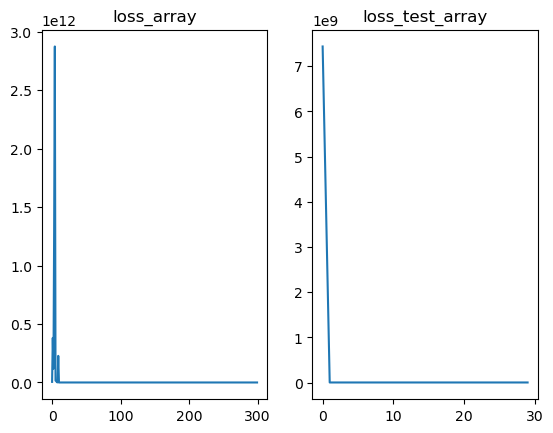

In [ ]:
import torch.optim as optim
nets_low = [NetworkDivided() for i in range(200)]
epochs = 300

loss_array = {}
loss_test_array = {}

nets_low,loss_array_low,loss_test_array_low = train(nets=nets_low,steps=[0])
# plot_loss(loss_array_low,loss_test_array_low,199)
# plot_loss(loss_array_low,loss_test_array_low,50)
plot_loss(loss_array_low,loss_test_array_low,0)



In [ ]:
def compare_spectrograms(original,modified):
    train_tensor_ftft, duration, sample_rate= calc_stft(original)
    filtered_signal_ftft,duration, sample_rate = calc_stft(modified)
    train_tensor_ftft = torch.abs(train_tensor_ftft)
    filtered_signal_ftft = torch.abs(filtered_signal_ftft)
    limit = sample_rate/2

    figure, axis = plt.subplots(1,2)
    vmin = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).min()
    vmax = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).max()
    im = axis[0].imshow(train_tensor_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[0].set_title('original Noise')
    axis[0].grid(True)
    axis[0].set_ylim(0.0, limit)
    axis[1].imshow(filtered_signal_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[1].set_title('model Noise')
    axis[1].grid(True)
    axis[1].set_ylim(0.0, limit)
    figure.colorbar(im,ax=axis.ravel().tolist(), label='Magnitude')
    plt.show()

In [ ]:
j=0
model_low = nets_low[j].to("cuda")
model_smpl = nets_smpl[j].to("cuda")
# model_low_ = nets_low_[j].to("cuda")
# model_high = nets_high[j].to("cuda")

test_inputs, gt_test = test_dataset.__getitem__(j)
test_inputs_low = test_inputs.view(1,1,-1).to("cuda", dtype=torch.float)

with torch.no_grad():
    output_test_low_mean, output_test_low_std = (model_low(test_inputs_low, "gt_test"))
    
with torch.no_grad():
    output_test_smpl_mean, output_test_smpl_std = (model_smpl(test_inputs_low, "gt_test"))


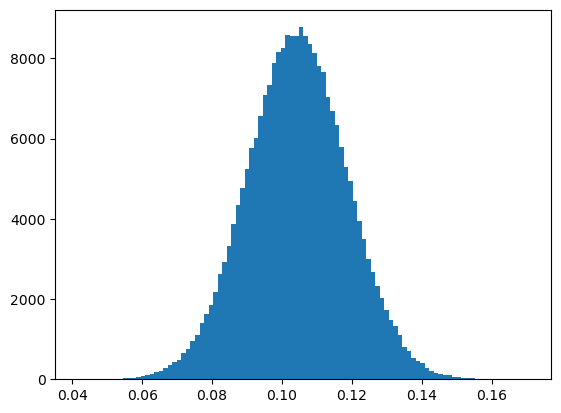

In [ ]:
_ = plt.hist(output_test_smpl_std.cpu(), bins=100)

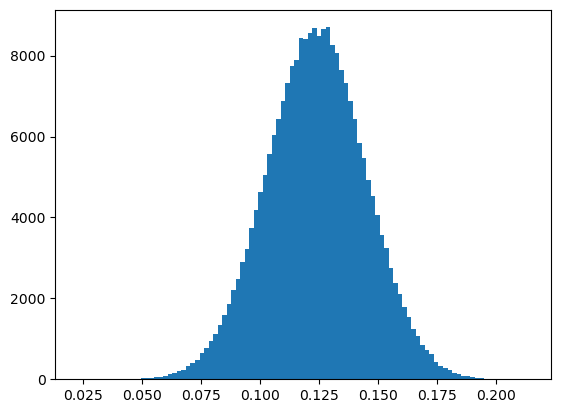

In [ ]:
_ = plt.hist(output_test_low_std.cpu(), bins=100)

In [47]:
output_test_low_mean, output_test_low_std = (model_low(test_inputs_low, "gt_test"))
loss = model_low.casual_loss( output_test_low_mean, output_test_low_std, wav_tensor=test_inputs_low)
loss

tensor([-321882.2812], device='cuda:0', grad_fn=<AddBackward0>)

In [55]:
loss = model_low.casual_loss( output_test_low_mean, output_test_low_std*0.1, wav_tensor=test_inputs_low)
loss

tensor([9647603.], device='cuda:0', grad_fn=<AddBackward0>)

In [48]:

loss = model_low.casual_loss( output_test_low_mean, torch.abs(output_test_low_mean/4), wav_tensor=test_inputs_low)
loss

tensor([2.0658e+13], device='cuda:0', grad_fn=<AddBackward0>)

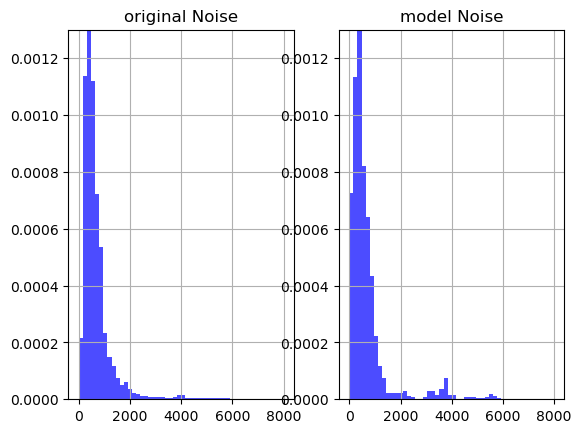

In [51]:
j=0

model_low = nets_low[j]
test_inputs, gt_test = test_dataset.__getitem__(j)
test_inputs_low = fir_filter(test_inputs, cutoff=6000, high=False, device="cuda")
test_inputs_low = test_inputs_low.view(1,1,-1).to("cuda", dtype=torch.float)
# gt_test = gt_test.to("cuda", dtype=torch.float)
# cur_test, curgt = test_dataset.__getitem__(j)
with torch.no_grad():
    output_test_low_mean, output_test_low_std = (model_low(test_inputs_low, "gt_test"))
    
# audio_output = torch.normal(output_test_low_mean, output_test_low_std*0).squeeze()
audio_output = torch.normal(output_test_low_mean, torch.abs(output_test_low_mean/10)).squeeze()


freqs1, magnitudes1 = signal.periodogram(test_inputs_low[0,:].squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.periodogram(audio_output.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

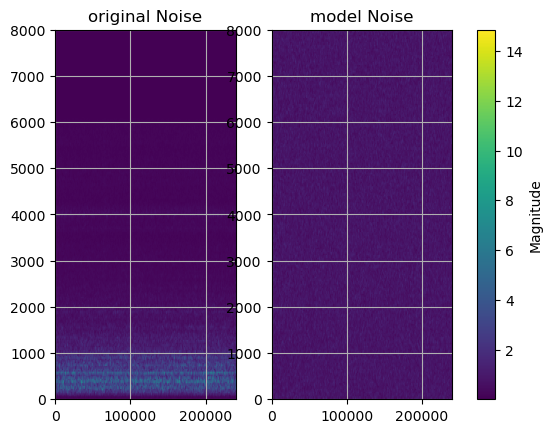

In [24]:
compare_spectrograms(test_inputs_low[0,:].squeeze().cpu(),audio_output.squeeze().cpu())

In [133]:
import torch.optim as optim
high = True
nets = [NetworkDivided() for i in range(200)]
epochs = 6000

loss_array = {}
loss_test_array = {}

nets_high,loss_array_high,loss_test_array_high = train(high=high,nets=nets)
plot_loss(loss_array_high,loss_test_array_high,199)
plot_loss(loss_array_high,loss_test_array_high,50)
plot_loss(loss_array_high,loss_test_array_high,0)


TypeError: train() missing 1 required positional argument: 'steps'

In [ ]:
# import pickle
# params_dict = {"nets": nets, "train_dataset": train_dataset, "test_dataset": test_dataset,"ar_coefs":ar_coefs, "loss_array":loss_array, "loss_test_array": loss_test_array, "ar_noise": ar_noise, "noise_scaling": noise_scaling_15, "snr": "15"}
# with open('exp3_scaled.pickle', 'wb') as handle:
#     pickle.dump(params_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#calc likelihood:
def calc_real_likelihood(inputs):
    SIGMA=1
    sum_arg=0
    wav_data2 = inputs.squeeze()

    # print(wav_data2[0])
    for i in range(len(wav_data2)-1):
        if i==0:
            sum_arg += (wav_data2[0] - 0)**2
        else:
            sum_arg += (wav_data2[i] - 0.9*wav_data2[i-1])**2
    # print("sum_arg:",sum_arg)
    # print("part1:", sum_arg*(-0.5)*((1/SIGMA)**2))
    # print("part2:", len(wav_data2)*np.log(1/(np.sqrt(2*np.pi)*SIGMA)))

    likelihood = sum_arg*(-0.5)*((1/SIGMA)**2) + len(wav_data2)*np.log(1/(np.sqrt(2*np.pi)*SIGMA))

    return likelihood

In [ ]:
def calc_model_likelihood(tensor_, curgt):
    with torch.no_grad():
        output = (model(tensor_.to("cuda"), curgt.to("cuda", dtype=torch.float)))
        # print(output)
        
    # sum_=0
    # wav_data2 = tensor_.squeeze()
    # means_=output[0].squeeze()
    # # stds_ = output[1].squeeze()
    # for i in range(len(wav_data2)-1):
    #     sum_ += -0.5*((wav_data2[i] - means_[i])/(stds_[i]))**2 +torch.log(1/(np.sqrt(2*np.pi)*stds_[i]))

    wav_tensor = tensor_.squeeze()
    means_=output[0].squeeze()
    stds_ = output[1].squeeze()

    exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
    param_all = 1/(np.sqrt(2*np.pi)*stds_)
    model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
    model_likelihood2 = torch.sum(exp_all, axis=-1) 

    model_likelihood = model_likelihood1 + model_likelihood2
    
    # model_likelihood = sum_
    return model_likelihood

In [ ]:
################################
#load
####################################

In [ ]:
import pickle
with open('/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real_2sec_divided/b/0_snr5_Babble_models.pickle', 'rb') as handle:
    params_dict = pickle.load(handle)

In [ ]:
params_dict.keys()

dict_keys(['nets_high', 'nets_low', 'train_dataset', 'test_dataset', 'ar_coefs', 'loss_array_high', 'loss_test_array_high', 'loss_array_low', 'loss_test_array_low', 'ar_noise', 'noise_scaling', 'snr', 'noise_name', 'noise_path'])

In [ ]:
j=199
g_t[j]

tensor(2.5623, dtype=torch.float64)

In [ ]:
model_high = params_dict["nets_high"][j]
model_low = params_dict["nets_low"][j]
loss_array = params_dict["loss_array_low"][j]
loss_test_array = params_dict["loss_test_array_low"][j]
ar_noise = params_dict["ar_noise"]
train_dataset = params_dict["train_dataset"]
test_dataset = params_dict["test_dataset"]
ar_coefs = params_dict["ar_coefs"]
#  "train_dataset": train_dataset, "test_dataset": test_dataset,"ar_coefs":ar_coefs, "loss_array":loss_array, "loss_test_array": loss_test_array, "ar_noise": ar_noise

In [ ]:
print(train_dataset)

None


Text(0.5, 1.0, 'loss_test_array')

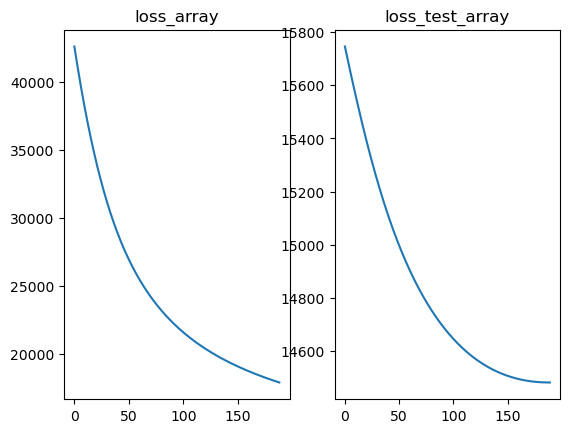

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
axs[0].plot(loss_array)
axs[0].set_title('loss_array')
axs[1].plot(loss_test_array)
axs[1].set_title('loss_test_array')

In [ ]:
def create_dataset_real(noise_whole, sr):
    noise_sample1 = noise_whole[:, int(3*sr):int(5*sr)]
    noise_sample2 = noise_whole[:,  int(1*sr):int(3*sr)]
    print("noise_sample2.shape:", noise_sample2.shape)

    # Create datasets and data loaders
    train_tensor = torch.tensor(noise_sample1, dtype=torch.float32).view(1,1,-1)
    test_tensor = torch.tensor(noise_sample2, dtype=torch.float32).view(1,1,-1)


    betas=get_named_beta_schedule("linear", 200)

    alphas = 1.0 - betas
    alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
    # white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
    g_t = -torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))

    train_full_tensors = train_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
        train_full_tensors[i,:,:] = train_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]

    test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
    for i in range(200):
        cur_white_noise_diffusion = torch.normal(0,1,test_tensor.shape)
        test_full_tensors[i,:,:] = test_full_tensors[i,:,:]+cur_white_noise_diffusion*g_t[i]
        

    #Create TensorDatasets
    train_dataset = NoiseDataset(train_full_tensors,g_t)
    test_dataset = NoiseDataset(test_full_tensors,g_t)

    #Create DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
    return train_dataset, test_dataset, noise_sample1, noise_sample2

In [ ]:
root = "/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real_2sec_divided/"


with open(Path(root)/'5f_snrs.pickle', 'rb') as handle:
    snr_df = pickle.load(handle)

snr_df2 = snr_df[(snr_df["dir"]=="b") & (snr_df["noise_idx"]=="Babble")  ]
snr_df2

,snr,noise_scaling,noise_idx,dir,clean_wav,noisy_wav,noise_path
37,5.0,0.816373,Babble,b,/data/ephraim/datasets/known_noise/undiff/exp_...,/data/ephraim/datasets/known_noise/undiff/exp_...,/data/ephraim/datasets/known_noise/undiff/exp_...


In [ ]:
print(snr_df2["noise_path"][37])

/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real/b/noises/noiseBabble_digits_snr5_power0.003250348847359419_var0.6664649844169617.wav


In [ ]:
train_dataset, test_dataset, noise_sample1, noise_sample2 = create_dataset_real(noise_whole, sr)

noise_sample2.shape: torch.Size([1, 32000])


/tmp/ipykernel_1080714/1234095121.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(noise_sample1, dtype=torch.float32).view(1,1,-1)
/tmp/ipykernel_1080714/1234095121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(noise_sample2, dtype=torch.float32).view(1,1,-1)


In [ ]:
cur_train, curgt = train_dataset.__getitem__(j)
cur_train = cur_train.view(1,1,-1).to("cuda", dtype=torch.float)

cur_train_low = fir_filter(cur_train, high=False, device="cuda")
meanst, stdst = model_low(cur_train_low, curgt)
lk = model_low.calc_model_likelihood(meanst, stdst,cur_train_low)  #expected_means, expected_stds, wav_tensor=train_tensor, verbose=Fals
print(lk)

tensor(-17503.4297, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
test_inputs, gt_test = test_dataset.__getitem__(j)
test_inputs_low = fir_filter(test_inputs, high=False, device="cuda")
test_inputs_low = test_inputs_low.view(1,1,-1).to("cuda", dtype=torch.float)
gt_test = gt_test.to("cuda", dtype=torch.float)
# meanst, stdst = model(test_inputs, gt_test)

In [ ]:
# j=0 #100
# model = nets[i].to("cuda")
# cur_test, curgt = test_dataset.__getitem__(j)
# cur_test = cur_test.view(1,1,-1).to("cuda", dtype=torch.float)
# curgt = curgt.to("cuda", dtype=torch.float)
# with torch.no_grad():
#         output_test_mean, output_test_std = (model(test_inputs, curgt))
# # audio_output = torch.normal(output_test_mean, output_test_std).squeeze().cpu().numpy()


In [ ]:
# cur_test, curgt = test_dataset.__getitem__(j)
with torch.no_grad():
    output_test_low_mean, output_test_low_std = (model_low(test_inputs_low, gt_test))

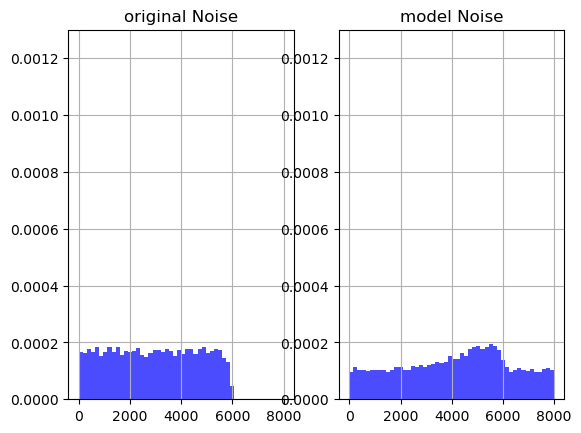

In [ ]:
audio_output = torch.normal(output_test_low_mean, output_test_low_std).squeeze()

freqs1, magnitudes1 = signal.periodogram(test_inputs_low[0,:].squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.periodogram(audio_output.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()